# Tutorial #1 - Basic - Calculating and filtering interactions

This tutorial covers: 
* Working with different Entry types (Mol, Ligand, etc)
* Using different filtering options to compute PPI, PLI, PNI, intra- or inter-molecular interactions
* Interaction granularity (proximal, covalent, non-covalent interactions)
* Applying filters on atomic groups or interactions using our built-in functions
* Creating a Pymol session to visualize interactions
* Plotting a Pymol session to depict hydrophobic contacts

### Import LUNA

In [1]:
import luna

luna.version

/home/alexandrefassio/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


### Note about ligands in PDB files

LUNA works with both Open Babel and RDKit. You can switch between both libraries when setting a new project. So, the choice between Open Babel and RDKit depends on the type of molecular file you are working with. If you have ligands in MOL or MOL2 files, for instance, you can use RDKit for your convenience as you will be able to apply RDKit functions directly on the molecular object stored at LUNA entries (as you will see in the next sections). However, if you frequently work with **ligands** in **PDB files**, you may be especially interested in reading this note.

Although each library has its own difficulties at parsing PDB files, we identified that Open Babel works better at parsing ligands from PDB files, especially what concerns ligands containing aromatic rings. FYI, it happens because PDB files don't contain information about atomic charges, valences, and bond types. Consequently, it may occur that some ligands are incorrectly perceived by Open Babel and RDKit.

For this reason, when working with ligands in PDB files, no matter you choose Open Babel or RDKit, we use Open Babel under the hood for parsing, amending, and converting ligands so that both final Open Babel and RDKit objects reflect at most the original and expected molecular structure.

However, in the past, I identified different errors in different Open Babel versions, which can be seen in this [issue thread]( https://github.com/openbabel/openbabel/issues/1925). During that time, I identified that Open Babel 2.3.2 works better for parsing PDB files. For the most common errors identified in this version, I implemented amending solutions like charge correction based on the OpenEye charge model, or valence correction. Since this solution was taken on basis of Open Babel 2.3.2, some errors from other versions may still persist.

Having that in mind, I started using two Open Babel versions in my projects, 2.3.2 for parsing/amending/converting molecules and 3.1.1 as the standard Python library to wrap the molecule as a Python object. By default, LUNA is configurated to use only the version 3.1.1 of Open Babel. So, if you work with PDB files and are also interested to use this strategy, you can change the OPENBABEL default executable at **luna/util/default_values.py**. There, modify the OPENBABEL variable to the executable of your preference. 
For example, in my local environment, you will find OPENBABEL set to "/usr/bin/obabel" that is the version 2.3.3.

## Entries

Entries determine the target molecule to which interactions and other properties will be calculated. They can be ligands, chains, etc, and can be defined in a number of ways. 
Each entry has an associated PDB file that may contain macromolecules (protein, RNA, DNA) and other small molecules, water, and ions. The PDB file provides the context to where the interactions with the target molecule will be calculated.

To define new entries, you need to import one of the following classes:

- **CompoundEntry**: define one residue, nucleotide, or small molecule in a PDB file;

- **MolEntry**: define one small molecule external to the PDB file, i.e., in a separate molecular file (MOL, MOL2, SDF). This is especially useful for molecular files obtained from docking. Thus, for your convenience, you don't need to convert the molecular file to PDB and add it to the PDB file containing the target structure.
    - In the case of molecular files containing multiple molecules (multimol file), you need to guarantee that the ligand id provided to the entry matches with the target molecule in the molecular file.
    
    
- **ChainEntry**: define a chain in a PDB file. The entire chain is used for calculating interactions. Thus, depending on the calculation granularity you choose, the calculation may take some time.

In [2]:
from luna.mol.entry import MolEntry, MolFileEntry, ChainEntry

### From a molecular file 

**MolEntry.from_mol_file()** expects the following parameters:
    
- **PDB id**: a PDB id or the filename for a local PDB file. In case, a local file does not exist, LUNA will try to download the PDB file from the RCSB protein data bank.
- **Ligand id**: a ligand identifier for reference in case of single molecular files or for identifying a corresponding structure at multimol files;
- **Path for the molecular file**;
- **If the molecular file is multimol or not**;

In [3]:
# Single molecular file
entry1 = MolFileEntry.from_mol_file("D4", "ZINC000007786517", "./inputs/ZINC000007786517.mol", 
                                    mol_obj_type='rdkit', is_multimol_file=False)
# Multimol file
entry2 = MolFileEntry.from_mol_file("D4", "ZINC000096459890", "./inputs/ligands.mol2", 
                                    mol_obj_type='rdkit', is_multimol_file=True)

To access the parsed molecule, you can use the property **mol_obj**, which returns a MolWrapper. A MolWrapper wraps Open Babel and RDKit objects and provides helper functions to deal with both libraries.

Below, we show how to visualize the molecules directly in the Jupyter notebook.

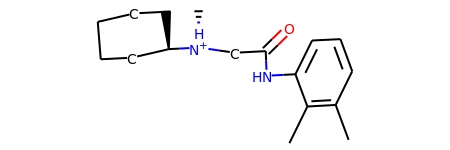

In [4]:
entry1.mol_obj

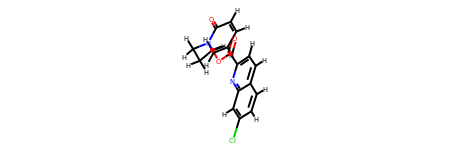

In [5]:
entry2.mol_obj

Observe that if you try the same using a molecule parsed with Open Babel, it will fail because Jupyter notebooks only support RDKit out-of-the-box. 

In [6]:
entry_ob = MolFileEntry.from_mol_file("D4", "ZINC000007786517", "./inputs/ZINC000007786517.mol", 
                                      mol_obj_type='openbabel', is_multimol_file=False)
entry_ob.mol_obj

To circumvent this, you may use the following helper function available for MolWrapper objects:

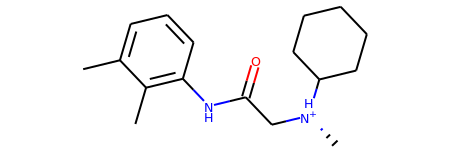

In [7]:
entry_ob.mol_obj.as_rdkit()

Below we list other useful functions available at MolWrapper:

- get_atoms(): returns all atoms in the molecule as an object AtomWrapper, which also provide helper functions for your convenience;
- get_bonds(): returns all bonds in the molecule as an object BondWrapper, which also provide helper functions for your convenience;
- to_smiles(): convert a molecule to SMILES;
- to_pdb_block(): convert a molecule to PDB and returns it as string;
- to_mol_block(): convert a molecule to PDB and returns it as string;
- unwrap(): returns the original Open Babel or RDKit object;


#### Visualize a molecule and the pharmacophoric features of its atoms

To depict a molecule with its atoms' pharmacophoric properties, you need to use the class **PharmacophoreDepiction** by passing a **FeatureExtractor** object, which is responsible for perceiving the pharmacophoric properties of the atoms in a given molecule. The example below shows how to create a new **FeatureExtractor** object and how to save an image file with the annotated molecule.

In [8]:
from luna.util.default_values import ATOM_PROP_FILE, ATOM_TYPES_COLOR
from rdkit.Chem import ChemicalFeatures
from luna.mol.features import FeatureExtractor
from luna.mol.depiction import PharmacophoreDepiction

# First, create a new ChemicalFeatures object. It expects a configuration file defined by the RDKit feature-typing format.
feature_factory = ChemicalFeatures.BuildFeatureFactory(ATOM_PROP_FILE)
# Then, instantiate the FeatureExtractor.
feature_extractor = FeatureExtractor(feature_factory)

# Instantiate a new PharmacophoreDepiction object with the desired parameters. For example, you can provide a color scheme to define the colors for each pharmacophoric property.
pd = PharmacophoreDepiction(feature_extractor=feature_extractor, colors=ATOM_TYPES_COLOR, fig_size=(500, 500), format="png")

output_path = "./outputs"
luna.util.file.create_directory(output_path) # Helper function for creating a new directory.
output_file = f"{output_path}/pharm_depiction.png"

# Now, just plot the molecule with the pharmacophoric properties annotated. You can use this in a For loop if there are multiple molecules.
pd.plot_fig(entry1.mol_obj, output_file)

To use the **PharmacophoreDepiction** in a Jupyter notebook, don't provide an output file to the **plot_fig()** and it will return a Drawer object. Then just plot it with the **Ipython.display** function.

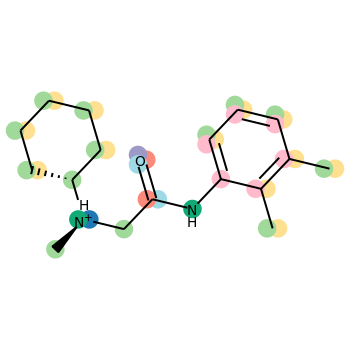

In [9]:
from IPython import display

pd = PharmacophoreDepiction(feature_extractor=feature_extractor, colors=ATOM_TYPES_COLOR, fig_size=(350, 350), format="png")
drawer = pd.plot_fig(entry1.mol_obj)

display.Image(drawer.GetDrawingText())

### From a PDB file

#### Recover entries from PDB files 

When you don't have the list of entries you want to work with, you can obtain them directly from a PDB file.

First, let's download a PDB file:

In [10]:
pdb_id = '3QQK'
output_path = "./outputs"

luna.util.file.create_directory(output_path) # Helper function for creating a new directory.

luna.MyBio.util.download_pdb(pdb_id=pdb_id, output_path=output_path) # Download the PDB file.

[2022-03-21 15:04:29]    INFO                file.py:187        The directory './outputs' already exists, but it will not be cleared.


In [11]:
from os.path import exists

exists(output_path) # confirm download

True

Now, parse the PDB file and use the function **recover_entries_from_entity** to get all ligands from it.

In [12]:
pdb_file = '%s/%s.pdb' % (output_path, pdb_id)

# BioPython part: parse a pdb file into a structure object.
PDB_PARSER = luna.MyBio.PDB.PDBParser(PERMISSIVE=True, QUIET=True, FIX_ATOM_NAME_CONFLICT=False, FIX_OBABEL_FLAGS=False)

structure = PDB_PARSER.get_structure(pdb_id, pdb_file)

# The function recover_entries_from_entity() allows you to recover all chains and ligands from a PDB file and returns a list of strings. 
# Setting get_chains = False recovers ligands only.
for entity_entry in luna.mol.entry.recover_entries_from_entity(structure, get_chains=False):
    print(entity_entry)

<MolEntry: 3QQK:A:X02:497>


In case, you are interested in ligands from a specific chain do the following:

In [13]:
model_id = 0
chain_id = "A"

for entity_entry in luna.mol.entry.recover_entries_from_entity(structure[model_id][chain_id], get_chains=False):
    print(entity_entry)

<MolEntry: 3QQK:A:X02:497>


#### Define PDB entries

**CompoundEntry** expects the following parameters:
    
- **PDB id**: a PDB id or the filename for a local PDB file. In case, a local file does not exist, LUNA will try to download the PDB file from the RCSB protein data bank.
- **Chain id**: the chain id where the target compound is;
- **Compound name**: the compound name as it is in the PDB file;
- **Compound number**: the compound number as it is in the PDB file;
- **Compound icode**: the compound insertion code if there is any;

In [14]:
# ligand entry - X02
X02_entry = MolEntry("3QQK", "A", "X02", 497)
print(X02_entry)

# or, if you already have a string representing the entry...
X02_entry = MolEntry.from_string("3QQK:A:X02:497")
print(X02_entry)

# You may also use different separators for your string if you will.
X02_entry = MolEntry.from_string("3QQK-A-X02-497", sep="-")
print(X02_entry)

<MolEntry: 3QQK:A:X02:497>
<MolEntry: 3QQK:A:X02:497>
<MolEntry: 3QQK-A-X02-497>


### From an input file

To create entries from an input file, you need to use the function **from_file()**, which exists in both **CompoundEntry** and **MolEntry** classes. Thus, if you are working with ligands in PDB files, call CompoundEntry.from_file(<INPUT_FILE>) or MolEntry.from_file(<INPUT_FILE>) whether you are working with ligands at external molecular files. 

See the examples below:

In [15]:
input_file = "./inputs/CompoundEntries.txt"
entries = MolEntry.from_file(input_file)

for e in entries:
    print(e)

<MolEntry: 3QL8:A:X01:300>
<MolEntry: 3QQF:A:X07:543>
<MolEntry: 3QQG:A:X06:300>
<MolEntry: 3QQH:A:X0A:303>
<MolEntry: 3QQJ:A:X11:300>


<MolFileEntry: D4:ZINC000012442563>
<MolFileEntry: D4:ZINC000065293174>
<MolFileEntry: D4:ZINC000096459890>
<MolFileEntry: D4:ZINC000343043015>
<MolFileEntry: D4:ZINC000575033470>



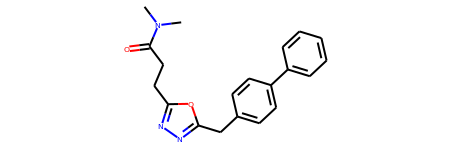

In [16]:
input_file = "./inputs/MolEntries.txt"
entries = list(MolFileEntry.from_file(input_file, pdb_id="D4", mol_file="./inputs/ligands.mol2", mol_obj_type="openbabel"))

for e in entries:
    print(e)
print()

entries[0].mol_obj.as_rdkit()

## Job setup

### Setting up parameters

In [17]:
opts = {}

opts['entries'] = entries  # The list of entries to calculate 
opts['working_path'] = "./outputs/luna_results"  # Where project results will be saved
opts['pdb_path'] = "./inputs"  # Path containing local PDB files or to where the PDB files will be downloaded. PDB filenames must match that defined for the entries.

opts['overwrite_path'] = False  # Allows script to overwrite directory - can remove files from previous project.

opts['add_h'] = True  # Define if you need to add Hydrogens or not.
opts['ph'] = 7.4  # Controls the pH and how the hydrogens are going to be added - default 7.4. It doesn't modify the protonation of molecular files defined by a MolEntry object.

# Whether or not to fix atomic charges, valence, and bond types for small molecules and residues at PDB files. 
# Only molecules at PDB files are validated because they don't contain charge, valence, and bond types. That causes molecules to be sometimes incorrectly perceived.
#
# This procedure is only applied for molecules at PDB files. Therefore, molecules from external files (MolEntry objects) won't be modified.
#
opts['amend_mol'] = True

opts['mol_obj_type'] = 'rdkit'  # What type of mol object, options are 'rdkit' and 'openbabel' - default rdkit
opts['calc_ifp'] = False  # Whether or not to calculate interaction fingerprints

opts['nproc'] = None  # Define how many processors to use. If you set it to None, LUNA will be run serially.

opts['binding_mode_filter'] = None  # Provide a BindingModeFilter object that specifies how to filter binding modes.

opts['logging_enabled'] = True  # Enable logger
opts['verbosity'] = 2  # How verbose is the logger

## Specifying what interactions to consider

### Interaction Configuration
This is the set of rules that define the distances and angles used to define the different types of interactions. The default configuration can be found in luna/interaction/calc.py. This can be modified to support different interaction definitions.

In [18]:
from luna.interaction.config import DefaultInteractionConfig

In [19]:
inter_config = DefaultInteractionConfig()
print(inter_config["max_da_dist_hb_inter"])

3.9


In [20]:
inter_config["max_da_dist_hb_inter"] = 4.0
print(inter_config["max_da_dist_hb_inter"])

4.0


In [21]:
inter_config['inter_conf'] = inter_config

### Interaction Filters
InteractionFilters can be used to define what interactions to include in the result. Each filter has a specific set of default parameters. Modifying these filter parameters further specifies which of those interactions to include, ex. "ignore_self_inter" to ignore intra-molecular interactions.

In [22]:
from luna.interaction.filter import InteractionFilter

In [23]:
pli_filter = InteractionFilter.new_pli_filter(ignore_self_inter = False) # protein-ligand interactions, including intra-molecular interactions
ppi_filter = InteractionFilter.new_ppi_filter() # protein-protein interactions
pni_filter = InteractionFilter.new_pni_filter() # protein-nucleotide interactions

### Interaction Calculator
Create an interaction calculator with the desired filter and add that to the project options. Like filters, calculators have parameters to control interaction granularity. These include add_non_cov, add_cov, and add_proximal. 

In [24]:
from luna.interaction.calc import InteractionCalculator

In [25]:
custom_filter = InteractionFilter.new_pli_filter() # protein-ligand interactions
inter_calc = InteractionCalculator(inter_filter=custom_filter, add_proximal=False)
opts['inter_calc'] = inter_calc

## Run project
This produces a chunks directory, logs directory, and a results directory

In [26]:
proj_obj = luna.projects.LocalProject(**opts)
proj_obj.run()

[2022-03-21 15:04:55]    INFO            projects.py:516        LUNA version: 0.11.0.
[2022-03-21 15:04:55]    INFO            projects.py:516        Verbosity set to: 2 (WARNING).
[2022-03-21 15:04:55]    WARNING         projects.py:516        The number of processes was set to 'None'. Therefore, LUNA will run jobs sequentially.
[2022-03-21 15:04:55]    INFO            projects.py:516        Preparing project directory './outputs/luna_results'.
[2022-03-21 15:04:55]    INFO                file.py:187        The directory './outputs/luna_results/results' already exists, but it will not be cleared.
[2022-03-21 15:04:55]    INFO            projects.py:516        Project directory './outputs/luna_results' created successfully.
[2022-03-21 15:04:55]    PROGRESS                               0% [                                                  ] 0/5 [Avg: 0.00s/task; Errors: 0] - Entries processing.

/media/data/Workspace/LUNA/luna/projects.py:467: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2022-03-21 15:05:45]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 10.02s/task; Errors: 0] - Entries processing.


In [27]:
! ls outputs/luna_results

chunks	logs  project_v0.11.0.pkl.gz  results


### Evaluate results

The results for each individual entry can be accessed through the corresponding EntryResult

In [28]:
entry_result = proj_obj.get_entry_results(entries[0])

In [29]:
print(f"Total number of interactions: {entry_result.interactions_mngr.size}")

Total number of interactions: 69


Count only interactions with the ligand.

In [30]:
entry_result.interactions_mngr.count_interations(must_have_target=True)

defaultdict(int,
            {'Van der Waals': 12,
             'Face-to-edge pi-stacking': 1,
             'Double bond': 9,
             'Weak hydrogen bond': 15,
             'Single bond': 18,
             'Tilted multipolar': 1,
             'Cation-pi': 1,
             'Hydrophobic': 8,
             'Displaced face-to-edge pi-stacking': 3,
             'Hydrogen bond': 1})

Count overall number of interactions per residue.

In [31]:
from luna.analysis.residues import generate_residue_matrix

In [32]:
residue_matrix = generate_residue_matrix(proj_obj.interactions_mngrs, by_interaction=False)
residue_matrix

residues,A/ARG/186,A/ASP/115,A/CYS/108;A/CYS/185,A/CYS/119,A/CYS/185,A/GLU/95,A/GLY/99,A/HIS/414,A/LEU/187,A/LEU/90,...,A/PHE/91,A/SER/196,A/SER/94,A/THR/434,A/TRP/101,A/TYR/438,A/VAL/116,A/VAL/193,A/VAL/430,A/VAL/87
entry,,,,,,,,,,,,,,,,,,,,,
ZINC000012442563,2,3,0,1,2,1,1,5,2,0,...,3,0,2,3,0,0,2,0,2,0
ZINC000065293174,3,4,0,0,2,1,0,5,1,0,...,2,0,2,2,0,0,2,0,1,0
ZINC000096459890,1,0,0,1,0,0,0,7,5,0,...,1,1,0,2,0,0,3,1,1,0
ZINC000343043015,1,3,0,0,3,1,1,2,3,0,...,1,0,2,5,0,0,2,0,0,0
ZINC000575033470,4,5,1,0,5,0,0,6,7,1,...,6,0,0,0,1,4,2,0,0,1


Count number of each type of interaction per residue.

In [33]:
residue_matrix = generate_residue_matrix(proj_obj.interactions_mngrs, by_interaction=True)
residue_matrix

residues                                             A/ARG/186  A/ASP/115  \
entry            interaction                                                
ZINC000012442563 Cation-nucleophile                          0          0   
                 Cation-pi                                   0          0   
                 Chalcogen bond                              0          0   
                 Displaced face-to-edge pi-stacking          0          0   
                 Face-to-edge pi-stacking                    0          0   
...                                                        ...        ...   
ZINC000575033470 Ionic                                       0          0   
                 Tilted multipolar                           0          0   
                 Unfavorable cation-electrophile             0          0   
                 Van der Waals                               2          2   
                 Weak hydrogen bond                          1          2   

residues                                             A/CYS/108;A/CYS/185  \
entry            interaction                                               
ZINC000012442563 Cation-nucleophile                                    0   
                 Cation-pi                                             0   
                 Chalcogen bond                                        0   
                 Displaced face-to-edge pi-stacking                    0   
                 Face-to-edge pi-stacking                              0   
...                                                                  ...   
ZINC000575033470 Ionic                                                 0   
                 Tilted multipolar                                     0   
                 Unfavorable cation-electrophile                       0   
                 Van der Waals                                         0   
                 Weak hydrogen bond                                    0   

residues                                             A/CYS/119  A/CYS/185  \
entry            interaction                                                
ZINC000012442563 Cation-nucleophile                          0          0   
                 Cation-pi                                   0          0   
                 Chalcogen bond                              0          0   
                 Displaced face-to-edge pi-stacking          0          0   
                 Face-to-edge pi-stacking                    0          0   
...                                                        ...        ...   
ZINC000575033470 Ionic                                       0          0   
                 Tilted multipolar                           0          1   
                 Unfavorable cation-electrophile             0          0   
                 Van der Waals                               0          3   
                 Weak hydrogen bond                          0          1   

residues                                             A/GLU/95  A/GLY/99  \
entry            interaction                                              
ZINC000012442563 Cation-nucleophile                         0         0   
                 Cation-pi                                  0         0   
                 Chalcogen bond                             0         0   
                 Displaced face-to-edge pi-stacking         0         0   
                 Face-to-edge pi-stacking                   0         0   
...                                                       ...       ...   
ZINC000575033470 Ionic                                      0         0   
                 Tilted multipolar                          0         0   
                 Unfavorable cation-electrophile            0         0   
                 Van der Waals                              0         0   
                 Weak hydrogen bond                         0         0   

residues                       

Let's visualize which residues established hydrogen bonds.

[Text(0, 0.5, 'ZINC000012442563'),
 Text(0, 1.5, 'ZINC000065293174'),
 Text(0, 2.5, 'ZINC000096459890'),
 Text(0, 3.5, 'ZINC000343043015'),
 Text(0, 4.5, 'ZINC000575033470')]

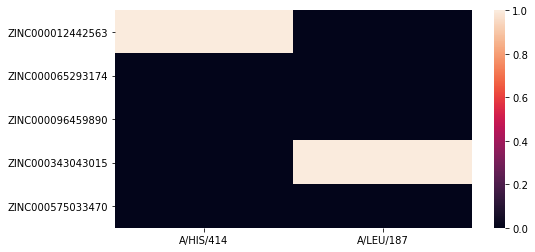

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

hb_matrix = residue_matrix.loc[ [i for i in residue_matrix.index if i[1] == "Hydrogen bond"] ]
hb_matrix = hb_matrix.loc[:, (hb_matrix != 0).any(axis=0)]

fig, ax = plt.subplots(figsize=(8, 4))
g = sns.heatmap(hb_matrix)

g.set_xlabel("")
g.set_ylabel("")

g.set_yticklabels([i[0] for i in hb_matrix.index])

Let's visualize which residues established weak hydrogen bonds.

[Text(0, 0.5, 'ZINC000012442563'),
 Text(0, 1.5, 'ZINC000065293174'),
 Text(0, 2.5, 'ZINC000096459890'),
 Text(0, 3.5, 'ZINC000343043015'),
 Text(0, 4.5, 'ZINC000575033470')]

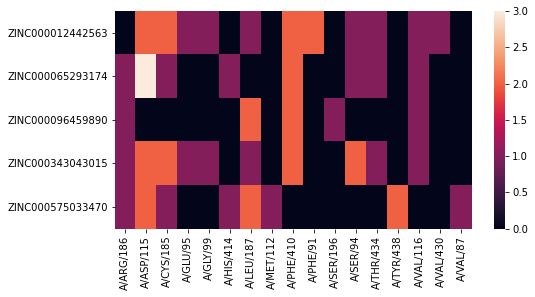

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

whb_matrix = residue_matrix.loc[ [i for i in residue_matrix.index if i[1] == "Weak hydrogen bond"] ]
whb_matrix = whb_matrix.loc[:, (whb_matrix != 0).any(axis=0)]

fig, ax = plt.subplots(figsize=(8, 4))
g = sns.heatmap(whb_matrix)

g.set_xlabel("")
g.set_ylabel("")

g.set_yticklabels([i[0] for i in whb_matrix.index])

#### Filter interactions by type

In [36]:
list(entry_result.interactions_mngr.filter_by_types(['Hydrogen bond']))

[<InteractionType: compounds=(<AtomGroup: [<ExtendedAtom: D4/0/A/HIS/414/NE2>]>, <AtomGroup: [<ExtendedAtom: D4/0/z/LIG/9999/N3>]>) type=Hydrogen bond>]

### Plotting interaction heatmaps

In [37]:
from luna.analysis.residues import generate_residue_matrix, heatmap

In [38]:
residue_matrix = generate_residue_matrix(proj_obj.interactions_mngrs, by_interaction=True)

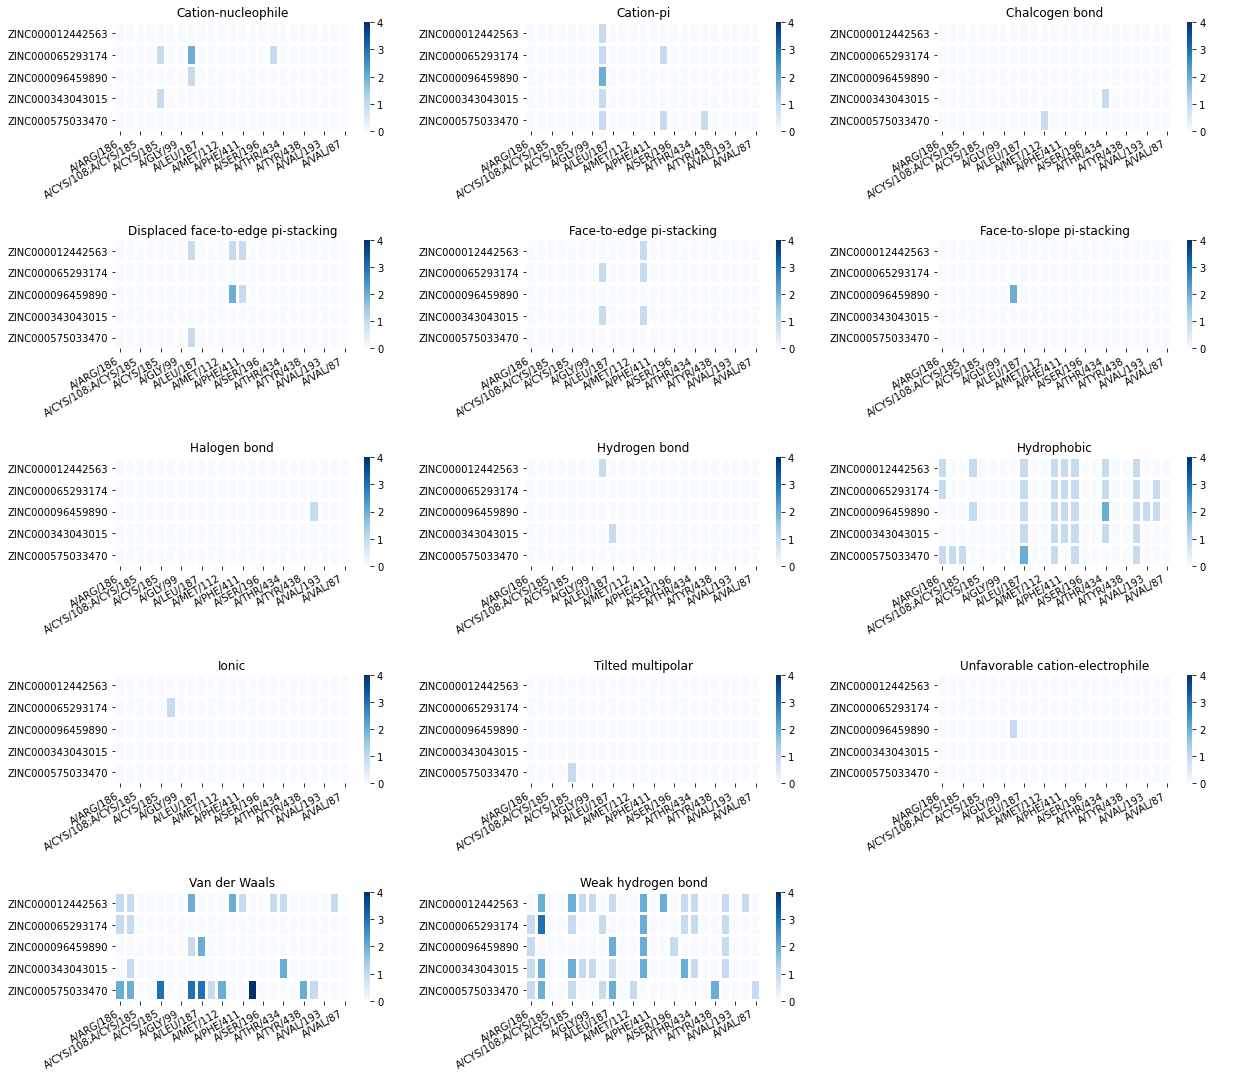

In [60]:
axs = heatmap(residue_matrix, cmap="Blues", figsize=(20, 18),
              heatmap_kw={"linewidths": 2},
              gridspec_kw={"wspace": 0.4, "hspace": 1, "ncols": 3}
             )

for ax in axs.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")

### Visualizing interactions in pymol

In [54]:
from luna.interaction.view import InteractionViewer

In [55]:
all_tuples = [(entries[0], entry_result.interactions_mngr, proj_obj.pdb_path)]
pse_file = "./outputs/D4-visualization-all.pse"

inter_view = InteractionViewer()
inter_view.new_session(all_tuples, pse_file)

 PyMOL not running, entering library mode (experimental)
 Applying pse_export_version=1.800 compatibility


### Visualizing specific types of interactions

In [56]:
hphobe_inter = list(entry_result.interactions_mngr.filter_by_types(['Hydrophobic']))

hp_tuples = [(entries[0], hphobe_inter, proj_obj.pdb_path)]
pse_file = "./outputs/D4-visualization-hydrophobic.pse"

# Show Hydrophobic interactions and surfaces in contact.
inter_view = InteractionViewer(show_hydrop_surface=True)
inter_view.new_session(hp_tuples, pse_file)

 Applying pse_export_version=1.800 compatibility


## Save full project or individual entry result

In [57]:
proj_obj.save(output_file = "./outputs/D4_proj")
entry_result.save(output_file = "./outputs/ZINC000007786517_entry")

## Reloading projects

In [2]:
reloaded_proj_obj = luna.projects.LocalProject.load("./outputs/luna_results")

print("# Entries defined previously: ", len(reloaded_proj_obj.entries))

for res in reloaded_proj_obj.results:
    print(res.entry.to_string(), "  =>  # interactions: ", len(res.interactions_mngr))

[2022-03-21 15:19:16]    INFO            projects.py:792        Reloading project saved in './outputs/luna_results/project_v0.11.0.pkl.gz'.

[2022-03-21 15:19:16]    INFO            projects.py:516        Verbosity set to: 3 (INFO).
[2022-03-21 15:19:16]    INFO            projects.py:516        Project reloaded successfully.
# Entries defined previously:  5
D4:ZINC000012442563   =>  # interactions:  69
D4:ZINC000065293174   =>  # interactions:  61


/media/data/Workspace/LUNA/luna/projects.py:467: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


D4:ZINC000096459890   =>  # interactions:  58
D4:ZINC000343043015   =>  # interactions:  51
D4:ZINC000575033470   =>  # interactions:  74
